The first step towards fitting a linear regression with time series modeling is setting up your workspace with the appropriate packages, and loading in the needed data. 

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv('data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']


Fitting a linear regression with a time-step feature:

In [3]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()
time =  np.arange(len(df))

df['time'] = time 

X = df[['time']]  
y = df[['sales']] 

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X)[:,0], index=X.index)
print(y_pred)

date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
                 ...    
2017-08-11    520.541320
2017-08-12    520.735667
2017-08-13    520.930014
2017-08-14    521.124361
2017-08-15    521.318708
Freq: D, Length: 1684, dtype: float64


Fitting a linear regression with lag features:

In [6]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print(y_pred)

date
2013-01-02     85.301689
2013-01-03    297.268250
2013-01-04    239.451340
2013-01-05    236.444550
2013-01-06    289.219421
                 ...    
2017-08-11    363.958893
2017-08-12    439.106384
2017-08-13    424.615509
2017-08-14    455.968994
2017-08-15    410.998535
Freq: D, Length: 1683, dtype: float32


Plot the results

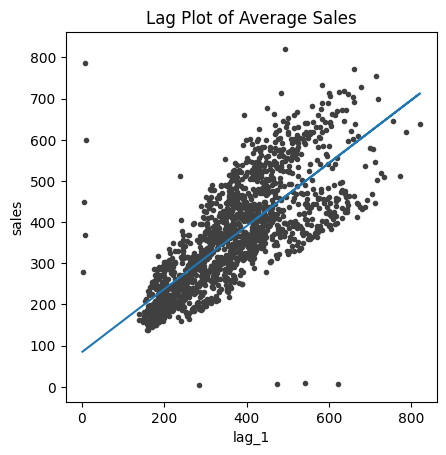

In [9]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

Combine features ( time + lag + day of the week)

In [13]:
df = average_sales.to_frame()

df['time'] = np.arange(len(df))

df['lag_1'] = df['sales'].shift(1)

df['dow'] = df.index.to_timestamp().dayofweek 
dow_dummies = pd.get_dummies(df['dow'], prefix='dow', drop_first=True)
df = pd.concat([df, dow_dummies], axis=1)

df = df.dropna()

X_train = df.drop(columns=['sales'])
y_train = df['sales']

Implementing test data

In [16]:
test_sales = pd.read_csv('data/test.csv',
    dtype=dtype,
    parse_dates=['date']
)

test_sales = test_sales.set_index('date').to_period('D')
test_sales = test_sales.set_index(['store_nbr', 'family'], append=True)

average_test_sales = test_sales.groupby('date').mean()

Add time, lag, and day of week to TEST

In [26]:
df_test = average_test_sales.copy()


df_test['time'] = np.arange(len(average_sales),
                            len(average_sales) + len(df_test))

last_train_value = average_sales.iloc[-1]

df_test['lag_1'] = np.nan
df_test.loc[df_test.index[0], 'lag_1'] = last_train_value

df_test['lag_1'] = df_test['lag_1'].ffill()

df_test['dow'] = df_test.index.to_timestamp().dayofweek
dow_dummies_test = pd.get_dummies(df_test['dow'], prefix='dow', drop_first=True)
df_test = pd.concat([df_test, dow_dummies_test], axis=1)

df_test = df_test.reindex(columns=X_train.columns, fill_value=0)

model = LinearRegression()
model.fit(X_train, y_train)

test_pred = model.predict(df_test)



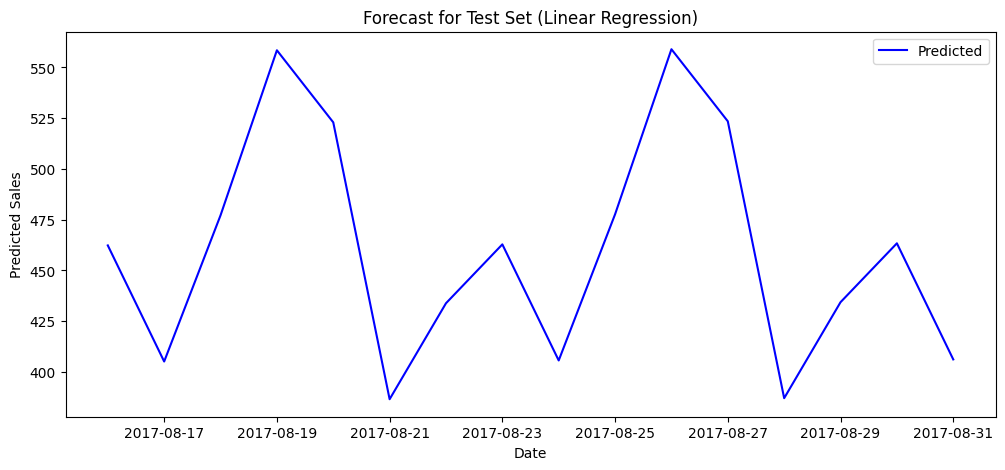

In [27]:

test_pred = pd.Series(test_pred, index=df_test.index, name='predicted_sales')

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_pred.index.to_timestamp(), test_pred, label='Predicted', color='blue')
plt.title("Forecast for Test Set (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# In-sample predictions on the training period
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index, name='fitted_sales')

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("Training MAE:", mae_train)
print("Training RMSE:", rmse_train)

Training MAE: 33.476085436674204
Training RMSE: 53.902349276847694


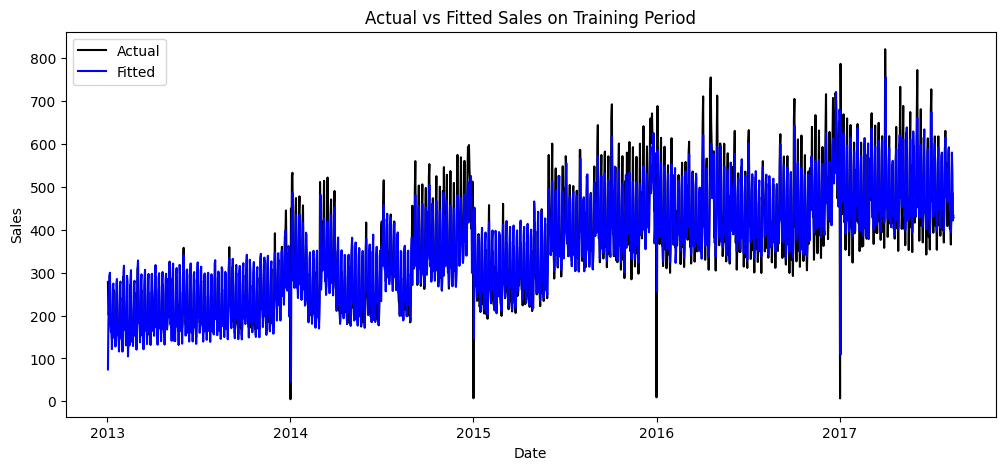

In [29]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index.to_timestamp(), y_train, label='Actual', color='black')
plt.plot(y_train_pred.index.to_timestamp(), y_train_pred, label='Fitted', color='blue')
plt.title("Actual vs Fitted Sales on Training Period")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()